# Import packages:


In [1]:
import random
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import pearsonr, randint, uniform
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sktime.split import ExpandingWindowSplitter
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.summarize import WindowSummarizer
from tqdm.notebook import tqdm

In [2]:
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
models_path = Path("../results/models/aemet//")

# Load data:


In [4]:
aemet_df = pd.read_parquet("../data/processed/aemet/aemet_monthly_data.parquet")

In [5]:
# convert float32 columns to float64
float32_cols = aemet_df.select_dtypes("float32").columns
aemet_df[float32_cols] = aemet_df[float32_cols].astype("float64")

In [6]:
olive_yield_df = pd.read_parquet("../data/processed/olive_yield/olive_yield.parquet")

In [7]:
aemet_df.dtypes

province                       object
date                   datetime64[ns]
temperature_average           float64
temperature_min               float64
temperature_max               float64
precipitation                 float64
wind_speed_average            float64
solar_radiation               float64
pressure_max                  float64
pressure_min                  float64
humidity_average              float64
humidity_max                  float64
humidity_min                  float64
dtype: object

# Split data:


In [8]:
common_years = np.intersect1d(aemet_df.date.dt.year, olive_yield_df.year)
common_provinces = np.intersect1d(
    aemet_df["province"].unique(), olive_yield_df["province"].unique()
)

In [9]:
print(f"Common years: {common_years}")
print(f"Common provinces: {common_provinces}")

Common years: [1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Common provinces: ['A Coruña' 'Alacant/Alicante' 'Albacete' 'Almería' 'Araba/Álava'
 'Asturias' 'Badajoz' 'Barcelona' 'Bizkaia' 'Burgos' 'Cantabria'
 'Castelló/Castellón' 'Ciudad Real' 'Cuenca' 'Cáceres' 'Cádiz' 'Córdoba'
 'Gipuzkoa' 'Girona' 'Granada' 'Guadalajara' 'Huelva' 'Huesca'
 'Illes Balears' 'Jaén' 'La Rioja' 'Las Palmas' 'León' 'Lleida' 'Lugo'
 'Madrid' 'Murcia' 'Málaga' 'Navarra' 'Ourense' 'Palencia' 'Pontevedra'
 'Salamanca' 'Santa Cruz de Tenerife' 'Segovia' 'Sevilla' 'Soria'
 'Tarragona' 'Teruel' 'Toledo' 'Valladolid' 'València/Valencia' 'Zamora'
 'Zaragoza' 'Ávila']


In [10]:
train_fraction = 0.8

In [11]:
train_years = common_years[: int(train_fraction * len(common_years))]
test_years = common_years[int(train_fraction * len(common_years)) :]

In [12]:
print(f"Train years: {train_years}")
print(f"Test years: {test_years}")

Train years: [1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017]
Test years: [2018 2019 2020 2021 2022]


In [13]:
X_train = aemet_df.loc[
    aemet_df.date.dt.year.isin(train_years)
    & aemet_df["province"].isin(common_provinces)
]

X_test = aemet_df.loc[
    aemet_df.date.dt.year.isin(test_years) & aemet_df["province"].isin(common_provinces)
]

y_train = olive_yield_df.loc[
    olive_yield_df.year.isin(train_years)
    & olive_yield_df["province"].isin(common_provinces),
    ["year", "province", "total"],
]

y_test = olive_yield_df.loc[
    olive_yield_df.year.isin(test_years)
    & olive_yield_df["province"].isin(common_provinces),
    ["year", "province", "total"],
]

In [14]:
y_train

,year,province,total
0,1998,A Coruña,0.0
1,1999,A Coruña,0.0
2,2000,A Coruña,0.0
3,2001,A Coruña,0.0
4,2002,A Coruña,0.0
...,...,...,...
1240,2013,Ávila,8418.0
1241,2014,Ávila,3337.0
1242,2015,Ávila,8633.0
1243,2016,Ávila,3458.0


# Handle missing values:


In [15]:
columns_to_impute = X_train.columns[X_train.isna().any()].tolist()
print(f"Columns to impute: {columns_to_impute}")

Columns to impute: ['wind_speed_average', 'solar_radiation', 'pressure_max', 'pressure_min', 'humidity_average', 'humidity_max', 'humidity_min']


In [16]:
imputer = Imputer(method="drift")

In [17]:
X_train.loc[:, columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])

In [18]:
X_test.loc[:, columns_to_impute] = imputer.transform(X_test[columns_to_impute])

# Tabularize AEMET data:


In [19]:
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}

months_order = list(month_mapping.keys())

In [20]:
X_train_tabular = (
    X_train.assign(
        year=lambda df_: df_.date.dt.year,
        month_name=lambda df_: pd.Categorical(
            df_.date.dt.month_name(),
            categories=months_order,
            ordered=True,
        ),
    )
    .sort_values(by=["province", "date"])
    .drop(columns=["date"])
    .pivot(index=["province", "year"], columns="month_name")
)

In [21]:
X_test_tabular = (
    X_test.assign(
        year=lambda df_: df_.date.dt.year,
        month_name=lambda df_: pd.Categorical(
            df_.date.dt.month_name(),
            categories=months_order,
            ordered=True,
        ),
    )
    .sort_values(by=["province", "date"])
    .drop(columns=["date"])
    .pivot(index=["province", "year"], columns="month_name")
)

In [22]:
X_train_tabular.columns = [f"{col[0]}_{col[1]}" for col in X_train_tabular.columns]
X_test_tabular.columns = [f"{col[0]}_{col[1]}" for col in X_test_tabular.columns]

In [23]:
X_train_tabular = X_train_tabular.reset_index()
X_test_tabular = X_test_tabular.reset_index()

In [24]:
X_train_tabular.head()

,province,year,temperature_average_January,temperature_average_February,temperature_average_March,temperature_average_April,temperature_average_May,temperature_average_June,temperature_average_July,temperature_average_August,...,humidity_min_March,humidity_min_April,humidity_min_May,humidity_min_June,humidity_min_July,humidity_min_August,humidity_min_September,humidity_min_October,humidity_min_November,humidity_min_December
0,A Coruña,1998,9.988094,11.536321,12.441422,10.119235,14.418141,16.454445,18.046505,20.075050,...,36.00,42.500000,39.000000,34.500000,50.400002,48.000000,48.599998,48.500000,45.400002,46.500000
1,A Coruña,1999,9.152256,8.902425,10.604539,11.836361,14.347068,16.049204,19.470419,18.975489,...,38.50,48.200001,46.000000,45.333332,37.200001,53.000000,44.250000,35.250000,38.666668,42.000000
2,A Coruña,2000,7.339028,10.464128,11.415758,9.997283,14.267318,17.073931,17.534859,18.101954,...,30.25,40.799999,43.500000,30.250000,47.250000,39.200001,49.799999,45.500000,48.250000,44.333332
3,A Coruña,2001,9.121552,9.727500,10.961342,11.235272,13.976892,17.075151,17.993587,18.783175,...,44.00,39.500000,31.666666,35.000000,44.000000,45.750000,42.000000,47.250000,40.599998,40.000000
4,A Coruña,2002,10.328691,10.189367,11.631114,11.561106,12.929267,15.833963,17.396406,18.268124,...,25.25,39.000000,50.000000,47.500000,42.500000,44.500000,40.599998,35.200001,48.750000,44.000000


In [25]:
X_test_tabular.head()

,province,year,temperature_average_January,temperature_average_February,temperature_average_March,temperature_average_April,temperature_average_May,temperature_average_June,temperature_average_July,temperature_average_August,...,humidity_min_March,humidity_min_April,humidity_min_May,humidity_min_June,humidity_min_July,humidity_min_August,humidity_min_September,humidity_min_October,humidity_min_November,humidity_min_December
0,A Coruña,2018,9.745892,7.931720,8.899711,12.071329,14.342832,17.072893,19.391373,20.367563,...,44.941177,42.111111,43.777779,51.250000,54.111111,38.944443,36.000000,30.941177,57.555557,43.166668
1,A Coruña,2019,8.732237,10.950166,11.472739,11.841079,15.084883,15.473943,19.337265,19.500328,...,26.555555,40.055557,28.055555,32.235294,48.555557,36.833332,43.823528,55.352940,67.062500,37.666668
2,A Coruña,2020,9.766979,11.771186,11.380160,13.324299,17.087898,16.697493,20.100306,19.411776,...,36.888889,37.000000,35.444443,49.944443,37.555557,47.722221,30.833334,47.388889,55.166668,57.277779
3,A Coruña,2021,8.389316,11.102953,11.290196,12.984074,13.671787,16.603224,18.175354,19.117393,...,29.333334,35.611111,42.888889,44.470589,36.823528,45.722221,40.111111,41.500000,51.647060,47.111111
4,A Coruña,2022,9.559697,10.304762,11.112618,11.965556,16.298746,17.068626,20.940786,20.370577,...,40.777779,33.444443,37.000000,54.352940,33.937500,47.055557,44.437500,51.111111,52.500000,55.000000


In [26]:
X_train_tabular = X_train_tabular.sort_values(by=["province", "year"]).set_index(
    keys=["province", "year"]
)

X_test_tabular = X_test_tabular.sort_values(by=["province", "year"]).set_index(
    keys=["province", "year"]
)

y_train = y_train.sort_values(by=["province", "year"]).set_index(
    keys=["province", "year"]
)

y_test = y_test.sort_values(by=["province", "year"]).set_index(
    keys=["province", "year"]
)

In [27]:
X_train_tabular.head()

temperature_average_January  temperature_average_February  \
province year                                                              
A Coruña 1998                     9.988094                     11.536321   
         1999                     9.152256                      8.902425   
         2000                     7.339028                     10.464128   
         2001                     9.121552                      9.727500   
         2002                    10.328691                     10.189367   

               temperature_average_March  temperature_average_April  \
province year                                                         
A Coruña 1998                  12.441422                  10.119235   
         1999                  10.604539                  11.836361   
         2000                  11.415758                   9.997283   
         2001                  10.961342                  11.235272   
         2002                  11.631114                  11.561106   

               temperature_average_May  temperature_average_June  \
province year                                                      
A Coruña 1998                14.418141                 16.454445   
         1999                14.347068                 16.049204   
         2000                14.267318                 17.073931   
         2001                13.976892                 17.075151   
         2002                12.929267                 15.833963   

               temperature_average_July  temperature_average_August  \
province year                                                         
A Coruña 1998                 18.046505                   20.075050   
         1999                 19.470419                   18.975489   
         2000                 17.534859                   18.101954   
         2001                 17.993587                   18.783175   
         2002                 17.396406                   18.268124   

               temperature_average_September  temperature_average_October  \
province year                                                               
A Coruña 1998                      17.361666                    13.971971   
         1999                      17.363251                    14.032649   
         2000                      16.968950                    12.813623   
         2001                      17.230551                    15.434803   
         2002                      17.816662                    15.324413   

               ...  humidity_min_March  humidity_min_April  humidity_min_May  \
province year  ...                                                             
A Coruña 1998  ...               36.00           42.500000         39.000000   
         1999  ...               38.50           48.200001         46.000000   
         2000  ...               30.25           40.799999         43.500000   
         2001  ...               44.00           39.500000         31.666666   
         2002  ...               25.25           39.000000         50.000000   

               humidity_min_June  humidity_min_July  humidity_min_August  \
province year                                                              
A Coruña 1998          34.500000          50.400002            48.000000   
         1999          45.333332          37.200001            53.000000   
         2000          30.250000          47.250000            39.200001   
         2001          35.000000          44.000000            45.750000   
         2002          47.500000          42.500000            44.500000   

               humidity_min_September  humidity_min_October  \
province year                                                 
A Coruña 1998               48.599998             48.500000   
         1999               44.250000             35.250000   
         2000               49.799999             45.500000   
         2001               42.000000             47.250000 

In [28]:
X_test_tabular.head()

temperature_average_January  temperature_average_February  \
province year                                                              
A Coruña 2018                     9.745892                      7.931720   
         2019                     8.732237                     10.950166   
         2020                     9.766979                     11.771186   
         2021                     8.389316                     11.102953   
         2022                     9.559697                     10.304762   

               temperature_average_March  temperature_average_April  \
province year                                                         
A Coruña 2018                   8.899711                  12.071329   
         2019                  11.472739                  11.841079   
         2020                  11.380160                  13.324299   
         2021                  11.290196                  12.984074   
         2022                  11.112618                  11.965556   

               temperature_average_May  temperature_average_June  \
province year                                                      
A Coruña 2018                14.342832                 17.072893   
         2019                15.084883                 15.473943   
         2020                17.087898                 16.697493   
         2021                13.671787                 16.603224   
         2022                16.298746                 17.068626   

               temperature_average_July  temperature_average_August  \
province year                                                         
A Coruña 2018                 19.391373                   20.367563   
         2019                 19.337265                   19.500328   
         2020                 20.100306                   19.411776   
         2021                 18.175354                   19.117393   
         2022                 20.940786                   20.370577   

               temperature_average_September  temperature_average_October  \
province year                                                               
A Coruña 2018                      19.586689                    14.674994   
         2019                      18.444180                    15.050017   
         2020                      18.679543                    14.202140   
         2021                      18.313181                    15.444455   
         2022                      18.384480                    16.729435   

               ...  humidity_min_March  humidity_min_April  humidity_min_May  \
province year  ...                                                             
A Coruña 2018  ...           44.941177           42.111111         43.777779   
         2019  ...           26.555555           40.055557         28.055555   
         2020  ...           36.888889           37.000000         35.444443   
         2021  ...           29.333334           35.611111         42.888889   
         2022  ...           40.777779           33.444443         37.000000   

               humidity_min_June  humidity_min_July  humidity_min_August  \
province year                                                              
A Coruña 2018          51.250000          54.111111            38.944443   
         2019          32.235294          48.555557            36.833332   
         2020          49.944443          37.555557            47.722221   
         2021          44.470589          36.823528            45.722221   
         2022          54.352940          33.937500            47.055557   

               humidity_min_September  humidity_min_October  \
province year                                                 
A Coruña 2018               36.000000             30.941177   
         2019               43.823528             55.352940   
         2020               30.833334             47.388889   
         2021               40.111111             41.500000 

In [29]:
print(f"Train: {X_train_tabular.shape}, {y_train.shape}")
print(f"Test: {X_test_tabular.shape}, {y_test.shape}")

Train: (1000, 132), (1000, 1)
Test: (250, 132), (250, 1)


# Window Features:


In [30]:
features_transformer = WindowSummarizer(
    lag_feature={
        "lag": [1],
        "mean": [[1, 3], [3, 6]],
        "std": [[1, 4]],
    },
    target_cols=[
        "temperature_average_August",
        "temperature_average_July",
        "temperature_min_September",
        "temperature_max_August",
        "temperature_average_December",
        "precipitation_April",
        "precipitation_May",
        "precipitation_June",
    ],
)

In [31]:
target_transformer = WindowSummarizer(
    lag_feature={
        "lag": [1],
        "mean": [[1, 3], [3, 6]],
        "std": [[1, 4]],
    },
    target_cols=["total"],
)

In [32]:
Z_train = pd.merge(
    left=X_train_tabular, right=y_train, left_index=True, right_index=True
)
Z_test = pd.merge(left=X_test_tabular, right=y_test, left_index=True, right_index=True)

In [33]:
Z_train_1 = features_transformer.fit_transform(Z_train)

In [34]:
Z_train_2 = target_transformer.fit_transform(Z_train_1)

In [35]:
Z_test_1 = features_transformer.transform(Z_test)
Z_test_2 = target_transformer.transform(Z_test_1)

In [36]:
X_train_window = Z_train_2.copy()
X_test_window = Z_test_2.copy()

In [37]:
print(f"X_train_window: {X_train_window.shape}")
print(f"X_test_window: {X_test_window.shape}")
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

X_train_window: (1000, 160)
X_test_window: (250, 160)
y train: (1000, 1)
y test: (250, 1)


In [38]:
X_train_window.head()

total_lag_1  total_mean_1_3  total_mean_3_6  total_std_1_4  \
province year                                                               
A Coruña 1998          NaN             NaN             NaN            NaN   
         1999          0.0             NaN             NaN            NaN   
         2000          0.0             NaN             NaN            NaN   
         2001          0.0             0.0             NaN            NaN   
         2002          0.0             0.0             NaN            0.0   

               temperature_average_August_lag_1  \
province year                                     
A Coruña 1998                               NaN   
         1999                         20.075050   
         2000                         18.975489   
         2001                         18.101954   
         2002                         18.783175   

               temperature_average_August_mean_1_3  \
province year                                        
A Coruña 1998                                  NaN   
         1999                                  NaN   
         2000                                  NaN   
         2001                            19.050831   
         2002                            18.620206   

               temperature_average_August_mean_3_6  \
province year                                        
A Coruña 1998                                  NaN   
         1999                                  NaN   
         2000                                  NaN   
         2001                                  NaN   
         2002                                  NaN   

               temperature_average_August_std_1_4  \
province year                                       
A Coruña 1998                                 NaN   
         1999                                 NaN   
         2000                                 NaN   
         2001                                 NaN   
         2002                            0.818291   

               temperature_average_July_lag_1  \
province year                                   
A Coruña 1998                             NaN   
         1999                       18.046505   
         2000                       19.470419   
         2001                       17.534859   
         2002                       17.993587   

               temperature_average_July_mean_1_3  ...  humidity_min_March  \
province year                                     ...                       
A Coruña 1998                                NaN  ...               36.00   
         1999                                NaN  ...               38.50   
         2000                                NaN  ...               30.25   
         2001                          18.350594  ...               44.00   
         2002                          18.332955  ...               25.25   

               humidity_min_April  humidity_min_May  humidity_min_June  \
province year                                                            
A Coruña 1998           42.500000         39.000000          34.500000   
         1999           48.200001         46.000000          45.333332   
         2000           40.799999         43.500000          30.250000   
         2001           39.500000         31.666666          35.000000   
         2002           39.000000         50.000000          47.500000   

               humidity_min_July  humidity_min_August  humidity_min_September  \
province year                                                                   
A Coruña 1998          50.400002            48.000000               48.599998   
         1999          37.200001            53.000000               44.250000   
         2000          47.250000            39.200001               49.799999   
         2001          44.000000            45.750000               42.000000   
         2002          42.500000            44.500000               40.599998   

               h

# Regression:


In [39]:
def evaluate_predictions(y_true, y_pred):
    """
    Evaluate the performance of a regression model by calculating various metrics.
    Parameters:
    - y_true (array-like): The true values of the target variable.
    - y_pred (array-like): The predicted values of the target variable.
    Returns:
    - dict: A dictionary containing the following metrics:
        - mean_absolute_error (float): The mean absolute error.
        - mean_squared_error (float): The mean squared error.
        - root_mean_squared_error (float): The root mean squared error.
        - r2_score (float): The coefficient of determination (R^2 score).
        - correlation (float): Pearson correlation coefficient.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)

    return {
        "mean_absolute_error": mae,
        "mean_squared_error": mse,
        "root_mean_squared_error": rmse,
        "r2_score": r2,
        "correlation": correlation,
    }

In [40]:
def get_feature_names(pipeline):
    if "poly" in dict(pipeline.named_steps):
        return pipeline.named_steps["poly"].get_feature_names_out(
            pipeline.named_steps["scaler"].get_feature_names_out()
        )
    else:
        return pipeline.named_steps["scaler"].get_feature_names_out()

In [41]:
def get_model_coefficients_or_importances(model):
    if hasattr(model, "coef_"):
        return model.coef_
    elif hasattr(model, "feature_importances_"):
        return model.feature_importances_
    else:
        return None

In [42]:
expanding_window_splitter = ExpandingWindowSplitter(
    fh=[1, 2, 3],
    initial_window=10,
    step_length=1,
)

In [43]:
models = [
    (
        "XGBoostRegressor",
        xgb.XGBRegressor(),
        {
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
            "model__n_estimators": range(50, 1000, 50),
            "model__max_depth": range(3, 12),
            "model__min_child_weight": range(1, 10),
        },
    ),
]

In [44]:
def run_random_search(model_name, model, param_grid, X, y):
    """
    Run a random search for hyperparameter tuning using a pipeline with optional polynomial features.
    Parameters:
    - model_name (str): The name of the model.
    - model (object): The machine learning model object.
    - param_grid (dict): The dictionary of hyperparameters to search over.
    - X (array-like): The input features.
    - y (array-like): The target variable.
    Returns:
    - random_search (object): The fitted RandomizedSearchCV object.
    """

    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", model),
        ]
    )

    if model_name in ["LinearRegression", "Ridge", "SGDRegressor"]:
        pipeline.steps.insert(1, ("poly", PolynomialFeatures()))
        param_grid["poly__degree"] = [1, 2]

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        n_iter=10,
        refit=True,
        cv=expanding_window_splitter.split(X),
        n_jobs=-1,
        random_state=random_seed,
    )

    random_search.fit(X, y["total"])

    model_path = models_path / f"{model_name}_best_model.pkl"
    joblib.dump(random_search.best_estimator_, model_path)

    return random_search

In [45]:
experiment_results = {}

for model_name, model, param_grid in tqdm(models):

    print(f"Running random search for {model_name}")

    experiment_results[model_name] = run_random_search(
        model_name, model, param_grid, X_train_window, y_train
    )

    print("===" * 20)

  0%|          | 0/1 [00:00<?, ?it/s]

Running random search for XGBoostRegressor


# Performance analysis:


In [46]:
models_metrics_df_list = []

for model_name, grid_search in experiment_results.items():
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_window)
    scores = evaluate_predictions(y_test["total"], y_pred)

    # Append the results to the list
    models_metrics_df_list.append(
        {
            "model_name": model_name,
            "mean_absolute_error": scores["mean_absolute_error"],
            "mean_squared_error": scores["mean_squared_error"],
            "root_mean_squared_error": scores["root_mean_squared_error"],
            "r2_score": scores["r2_score"],
            "correlation": scores["correlation"],
        }
    )

models_metrics_df = pd.DataFrame(models_metrics_df_list)
models_metrics_df = models_metrics_df.assign(dataset="window-features")

In [47]:
models_metrics_df.sort_values(by="r2_score", ascending=False)

,model_name,mean_absolute_error,mean_squared_error,root_mean_squared_error,r2_score,correlation,dataset
0,XGBoostRegressor,50036.929688,1.840394e+10,135661.109375,0.89165,0.948195,window-features


In [48]:
models_metrics_df.to_clipboard()

In [49]:
good_models = models_metrics_df.loc[
    models_metrics_df["r2_score"] > 0, "model_name"
].tolist()
print(good_models)

['XGBoostRegressor']


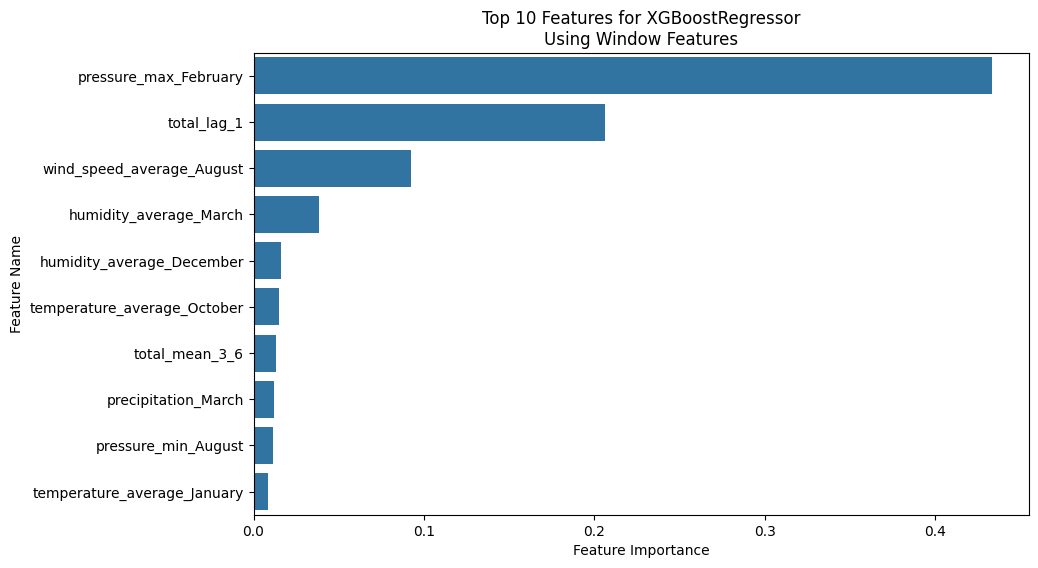

In [50]:
models_feature_importance_df_list = []

for model_name in good_models:
    best_pipeline = experiment_results[model_name].best_estimator_
    feature_names = get_feature_names(best_pipeline)
    coefficients_or_importances = get_model_coefficients_or_importances(
        best_pipeline.named_steps["model"]
    )

    if coefficients_or_importances is not None:
        model_feature_importance = (
            pd.DataFrame(
                {
                    "feature_name": feature_names,
                    "feature_importance": coefficients_or_importances.squeeze(),
                }
            )
            .sort_values(by="feature_importance", ascending=False)
            .head(10)
        )
        model_feature_importance["model_name"] = model_name
        models_feature_importance_df_list.append(model_feature_importance)

# Concatenate all results
models_feature_importance_df = pd.concat(
    models_feature_importance_df_list, ignore_index=True
)

for model in good_models:
    plt.figure(figsize=(10, 6))
    model_data = models_feature_importance_df[
        models_feature_importance_df["model_name"] == model
    ]
    sns.barplot(x="feature_importance", y="feature_name", data=model_data)
    plt.title(f"Top 10 Features for {model}\nUsing Window Features")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.show()

In [51]:
for model_name in good_models:
    model = experiment_results[model_name]
    model.best_estimator_.fit(X_train_tabular, y_train["total"])
    train_pred = model.best_estimator_.predict(X_train_tabular)
    test_pred = model.best_estimator_.predict(X_test_tabular)

    y_train[f"{model_name}_total"] = train_pred
    y_test[f"{model_name}_total"] = test_pred

true_vs_pred_df = pd.concat([y_train, y_test], axis=0).reset_index()

In [52]:
from sklearn.metrics import PredictionErrorDisplay

In [53]:
y_pred.shape

(250,)

In [54]:
from sklearn.metrics import PredictionErrorDisplay

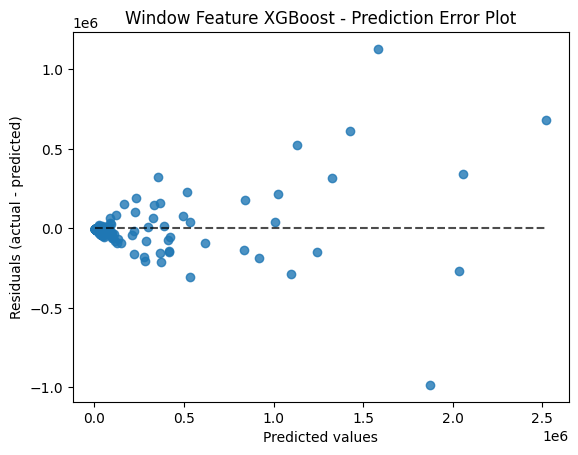

In [55]:
PredictionErrorDisplay.from_predictions(y_test["total"], y_pred)
plt.title("Window Feature XGBoost - Prediction Error Plot")
plt.show()

In [56]:
jaen_data = true_vs_pred_df.query("province == 'Jaén'").set_index("year")

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Jaén Olive Yield - True vs. Predicted\nWindow Features XGBoost'}, ylabel='total'>)

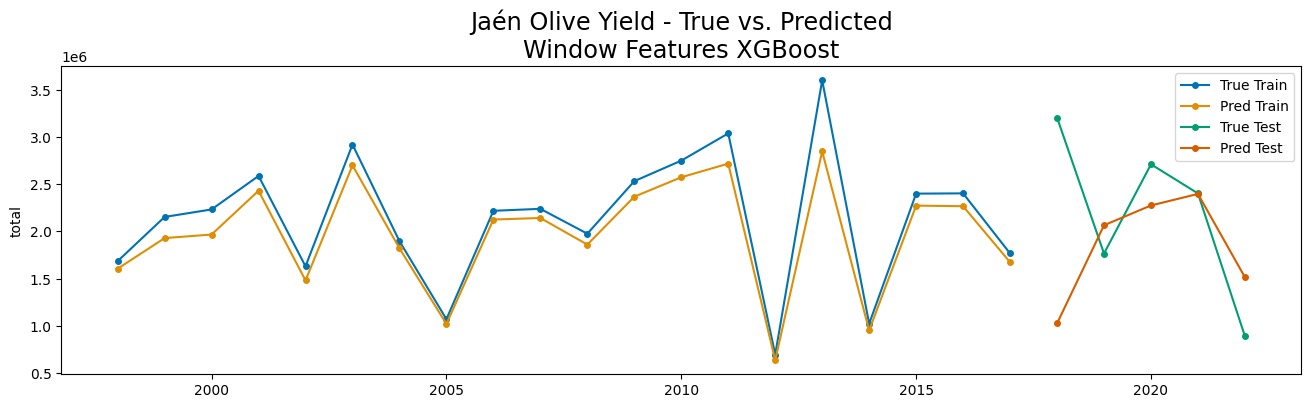

In [57]:
from sktime.utils.plotting import plot_series

plot_series(
    jaen_data.loc[train_years, "total"],
    jaen_data.loc[train_years, "XGBoostRegressor_total"],
    jaen_data.loc[test_years, "total"],
    jaen_data.loc[test_years, "XGBoostRegressor_total"],
    labels=["True Train", "Pred Train", "True Test", "Pred Test"],
    title="Jaén Olive Yield - True vs. Predicted\nWindow Features XGBoost",
)